In [1]:
!pip install pycocoevalcap
!pip install wordfreq

In [2]:
import torch
import gc

gc.collect()                      # gom rác Python
torch.cuda.empty_cache()          # trả lại VRAM chưa dùng cho driver
torch.cuda.ipc_collect()          # dọn shared memory CUDA (nếu có)
!nvidia-smi


Sat Dec 20 11:40:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             25W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from torchvision import transforms
from tqdm import tqdm
from datasets import load_dataset
from typing import List
from collections import Counter
import re
import timm
import matplotlib.pyplot as plt
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Device: cuda


In [4]:
class SimpleTokenizer:
    def __init__(self, vocab: List[str]):
        specials = ["<pad>", "<bos>", "<eos>", "<unk>"]
        vocab = specials + [w for w in vocab if w not in specials]
        self.stoi = {w: i for i, w in enumerate(vocab)}
        self.itos = {i: w for w, i in self.stoi.items()}
        self.pad_id = self.stoi["<pad>"]
        self.bos_id = self.stoi["<bos>"]
        self.eos_id = self.stoi["<eos>"]
        self.unk_id = self.stoi["<unk>"]

    def encode(self, text: str) -> List[int]:
        text = text.lower().strip()
        # Tách punctuation
        text = re.sub(r"([.!?,;:])", r" \1 ", text)
        text = re.sub(r"\s+", " ", text).strip()
        tokens = text.split()
        return [self.stoi.get(t, self.unk_id) for t in tokens]

    def decode(self, ids: List[int]) -> str:
        toks = []
        for i in ids:
            if i in (self.pad_id, self.bos_id, self.eos_id):
                continue
            toks.append(self.itos.get(i, "<unk>"))
        return " ".join(toks)


def collect_rsicd_words(hf_train, hf_val, min_freq=3):
    cnt = Counter()
    for split in [hf_train, hf_val]:
        for ex in split:
            cap = ex["captions"]
            if isinstance(cap, list):
                for c in cap:
                    text = c.lower().strip()
                    text = re.sub(r"([.!?,;:])", r" \1 ", text)
                    text = re.sub(r"\s+", " ", text).strip()
                    cnt.update(text.split())
            else:
                text = cap.lower().strip()
                text = re.sub(r"([.!?,;:])", r" \1 ", text)
                text = re.sub(r"\s+", " ", text).strip()
                cnt.update(text.split())
    words = [w for w, freq in cnt.most_common() if freq >= min_freq]
    return words


# Load dataset
print("Loading dataset...")
ds = load_dataset("arampacha/rsicd")
rsicd_words = collect_rsicd_words(ds["train"], ds["valid"], min_freq=3)
print(f"RSICD unique words (freq >=3): {len(rsicd_words)}")

try:
    from wordfreq import top_n_list
    gigaword_top = top_n_list("en", n=5000)
    merged = list(dict.fromkeys(rsicd_words + gigaword_top))
    print(f"After adding wordfreq top-5k: {len(merged)}")
except:
    print("Wordfreq not available, using RSICD only")
    merged = rsicd_words

tokenizer = SimpleTokenizer(merged)
print(f"Final vocab size: {len(tokenizer.stoi)}")

Loading dataset...
RSICD unique words (freq >=3): 1569
After adding wordfreq top-5k: 5743
Final vocab size: 5747


In [5]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])
class RSICDDataset(Dataset):
    def __init__(self, hf_split, tokenizer, transform=None, max_len=30, is_train=True, n_caps=5):
        self.data = hf_split
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_len
        self.is_train = is_train
        self.n_caps = n_caps

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        ex = self.data[idx]

        # Load image
        img_path = ex.get("image_path", ex.get("image"))
        if isinstance(img_path, str):
            image = Image.open(img_path).convert("RGB")
        else:
            image = ex["image"]
            if not isinstance(image, Image.Image):
                image = Image.fromarray(np.array(image))
        
        if self.transform is not None:
            image = self.transform(image)

        # Get captions
        caps = ex["captions"]
        if isinstance(caps, str):
            caps = [caps]
        caps = [c.strip() for c in caps if isinstance(c, str) and c.strip()]
        caps = caps[:self.n_caps]
        
        # Pad if needed
        while len(caps) < self.n_caps:
            caps.append(caps[0])

        return image, caps


def collate_fn_train(batch):
    """Training collate: random 1 caption per image"""
    images_list = []
    captions_ids = []
    
    for image, caps in batch:
        # Random pick 1 caption
        cap = random.choice(caps)
        images_list.append(image)
        
        ids = tokenizer.encode(cap)
        ids = [tokenizer.bos_id] + ids + [tokenizer.eos_id]
        ids = ids[:max_len]
        pad_len = max_len - len(ids)
        if pad_len > 0:
            ids = ids + [tokenizer.pad_id] * pad_len
        captions_ids.append(torch.tensor(ids, dtype=torch.long))
    
    images = torch.stack(images_list, dim=0)
    captions_ids = torch.stack(captions_ids, dim=0)
    
    return images, captions_ids, None


def collate_fn_eval(batch):
    """Evaluation collate: keep all 5 captions"""
    images_list = []
    all_caps_batch = []
    
    for image, caps in batch:
        images_list.append(image)
        all_caps_batch.append(caps)
    
    images = torch.stack(images_list, dim=0)
    
    return images, None, all_caps_batch

In [6]:
class ViTEncoder(nn.Module):
    def __init__(
        self,
        model_name="vit_base_patch16_224.mae",
        output_dim=768,
        dropout_p=0.2,
        n_finetune_blocks=6,
        use_task_cls=True
    ):
        super().__init__()
        vit = timm.create_model(model_name, pretrained=True)
        vit.head = nn.Identity()
        self.vit = vit
        vit_dim = vit.num_features

        # Freeze tất cả, mở n_finetune_blocks cuối
        for p in self.vit.parameters():
            p.requires_grad = False
        
        if n_finetune_blocks > 0:
            for blk in self.vit.blocks[-n_finetune_blocks:]:
                for p in blk.parameters():
                    p.requires_grad = True
        
        for p in self.vit.norm.parameters():
            p.requires_grad = True

        # Task-specific CLS token
        self.use_task_cls = use_task_cls
        if use_task_cls:
            self.task_cls = nn.Parameter(torch.zeros(1, 1, vit_dim))
            nn.init.trunc_normal_(self.task_cls, std=0.02)

        # Improved projection head
        self.proj = nn.Sequential(
            nn.Linear(vit_dim, output_dim * 2),
            nn.LayerNorm(output_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout_p),
            nn.Linear(output_dim * 2, output_dim),
            nn.LayerNorm(output_dim),
            nn.Dropout(dropout_p * 0.5)
        )
        
        # Spatial attention for better patch features
        self.spatial_attn = nn.MultiheadAttention(
            output_dim, num_heads=8, dropout=dropout_p, batch_first=True
        )

    def forward(self, x):
        B = x.size(0)
        
        # ViT features
        feats = self.vit.forward_features(x)
        
        if self.use_task_cls:
            cls_token = self.task_cls.expand(B, -1, -1)
            patch_tokens = feats[:, 1:, :]
            feats = torch.cat([cls_token, patch_tokens], dim=1)
        
        # Project
        feats = self.proj(feats)
        
        global_feats = feats[:, 0]
        spatial_feats = feats[:, 1:]
        
        # Self-attention on spatial features
        spatial_feats, _ = self.spatial_attn(spatial_feats, spatial_feats, spatial_feats)
        
        return spatial_feats, global_feats


# ============================================================================
# DECODER - Improved Transformer with better architecture
# ============================================================================
class TransformerDecoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model=768,
        nhead=12,
        num_layers=6,
        dim_feedforward=3072,
        dropout=0.2,
        pad_idx=0,
        max_len=128
    ):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.pad_idx = pad_idx
        self.max_len = max_len

        # Embeddings
        self.embed = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_embed = nn.Embedding(max_len, d_model)
        
        # Input dropout
        self.input_dropout = nn.Dropout(dropout)

        # Decoder layers
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
            activation="gelu"
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Output layers
        self.out_norm = nn.LayerNorm(d_model)
        self.out_dropout = nn.Dropout(dropout * 0.5)
        
        # Two-layer output head
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout * 0.5),
            nn.Linear(d_model, vocab_size)
        )

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.normal_(self.embed.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.pos_embed.weight, mean=0.0, std=0.02)

    def _build_causal_mask(self, T, device):
        mask = torch.full((T, T), float("-inf"), device=device)
        mask = torch.triu(mask, diagonal=1)
        return mask

    def forward(self, spatial_feats, global_feats, caption_ids, enc_padding_mask=None):
        B, T = caption_ids.size()
        device = caption_ids.device

        # Embeddings with scaling
        tok_emb = self.embed(caption_ids) * (self.d_model ** 0.5)
        pos = torch.arange(T, device=device).unsqueeze(0).expand(B, T)
        pos_emb = self.pos_embed(pos)
        tgt = tok_emb + pos_emb
        tgt = self.input_dropout(tgt)

        # Memory
        memory = torch.cat([global_feats.unsqueeze(1), spatial_feats], dim=1)

        # Masks
        tgt_mask = self._build_causal_mask(T, device)
        tgt_key_padding_mask = caption_ids.eq(self.pad_idx)

        # Decode
        out = self.decoder(
            tgt,
            memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=enc_padding_mask
        )
        
        out = self.out_norm(out)
        out = self.out_dropout(out)
        logits = self.fc(out)
        
        return logits

In [7]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, caption_ids):
        spatial_feats, global_feats = self.encoder(images)
        logits = self.decoder(spatial_feats, global_feats, caption_ids[:, :-1])
        return logits

    def sample_caption_transformer(self, images, tokenizer, max_len=30, sample=True, temperature=1.0):
        """Fixed sampling with proper log probs"""
        device = images.device
        spatial_feats, global_feats = self.encoder(images)
        
        B = images.size(0)
        bos_id = tokenizer.bos_id
        eos_id = tokenizer.eos_id
        
        seqs = torch.full((B, 1), bos_id, dtype=torch.long, device=device)
        log_probs = []
        
        for t in range(1, max_len):
            logits = self.decoder(spatial_feats, global_feats, seqs)
            step_logits = logits[:, -1, :] / temperature
            step_log_probs = F.log_softmax(step_logits, dim=-1)
            
            if sample:
                probs = step_log_probs.exp()
                next_tokens = torch.multinomial(probs, num_samples=1)
            else:
                next_tokens = step_log_probs.argmax(dim=-1, keepdim=True)
            
            seqs = torch.cat([seqs, next_tokens], dim=1)
            log_probs.append(step_log_probs.gather(1, next_tokens).squeeze(1))
            
            # Early stopping if all beams generated EOS
            if (next_tokens == eos_id).all():
                break
        
        log_probs = torch.stack(log_probs, dim=1) if log_probs else torch.zeros(B, 0, device=device)
        return seqs, log_probs

    def generate_caption_beam(
        self,
        image,
        tokenizer,
        max_len=30,
        beam_size=5,
        alpha=0.7,
        block_ngram=3,
        device="cuda"
    ):
        """Fixed beam search with proper finished handling"""
        self.eval()
        
        if image.dim() == 3:
            image = image.unsqueeze(0)
        image = image.to(device)
        
        spatial_feats, global_feats = self.encoder(image)
        
        bos_id = tokenizer.bos_id
        eos_id = tokenizer.eos_id
        pad_id = tokenizer.pad_id
        vocab_size = self.decoder.vocab_size
        
        # Initialize
        seqs = torch.full((beam_size, 1), bos_id, dtype=torch.long, device=device)
        log_probs = torch.zeros(beam_size, device=device)
        finished = torch.zeros(beam_size, dtype=torch.bool, device=device)
        
        spatial_feats = spatial_feats.expand(beam_size, -1, -1)
        global_feats = global_feats.expand(beam_size, -1)
        
        for t in range(1, max_len + 1):
            if finished.all():
                break
            
            with torch.no_grad():
                logits = self.decoder(spatial_feats, global_feats, seqs)
                step_logits = logits[:, -1, :]
                step_log_probs = F.log_softmax(step_logits, dim=-1)
            
            # Block pad token
            step_log_probs[:, pad_id] = -1e9
            
            # FIXED: Proper handling of finished beams
            total_log_probs = log_probs.unsqueeze(1) + step_log_probs
            
            if finished.any():
                # Finished beams can only generate PAD with same score
                total_log_probs[finished, :] = -1e9
                total_log_probs[finished, pad_id] = log_probs[finished]
            
            # N-gram blocking
            if block_ngram > 0 and seqs.size(1) >= block_ngram:
                for b in range(beam_size):
                    if finished[b]:
                        continue
                    seq_b = seqs[b].tolist()
                    # Block all ngrams that appeared before
                    for i in range(len(seq_b) - block_ngram + 1):
                        ngram = tuple(seq_b[i:i+block_ngram])
                        # Find tokens that would complete this ngram
                        if len(seq_b) >= block_ngram - 1:
                            prefix = tuple(seq_b[-(block_ngram-1):])
                            for tok in range(vocab_size):
                                if prefix + (tok,) == ngram:
                                    total_log_probs[b, tok] -= 5.0
            
            # Select top-k
            flat_log_probs = total_log_probs.view(-1)
            topk_log_probs, topk_indices = flat_log_probs.topk(beam_size, dim=-1)
            
            beam_indices = topk_indices // vocab_size
            token_indices = topk_indices % vocab_size
            
            # Update sequences
            seqs = torch.cat([seqs[beam_indices], token_indices.unsqueeze(1)], dim=1)
            log_probs = topk_log_probs
            finished = finished[beam_indices] | (token_indices == eos_id)
        
        # Length penalty
        lengths = (seqs != pad_id).sum(dim=1).float()
        lengths = torch.clamp(lengths - 1, min=1.0)
        lp = ((5.0 + lengths) / 6.0) ** alpha
        scores = log_probs / lp
        
        # Return best
        best_idx = scores.argmax().item()
        best_seq = seqs[best_idx].tolist()
        best_seq = [tok for tok in best_seq if tok not in (bos_id, eos_id, pad_id)]
        
        return best_seq

In [8]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, vocab_size, padding_idx, smoothing=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            # FIXED: vocab_size - 1 (chỉ trừ padding)
            true_dist.fill_(self.smoothing / (self.vocab_size - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
            true_dist[:, self.padding_idx] = 0
            mask = (target == self.padding_idx)
            true_dist[mask] = 0
        
        loss = -(true_dist * pred).sum(dim=-1)
        loss = loss.masked_fill(mask, 0).sum() / (mask == 0).sum()
        return loss


In [9]:
def train_one_epoch_xe(model, loader, optimizer, criterion, device, grad_clip=1.0):
    model.train()
    total_loss = 0.0
    
    for images, caption_ids, _ in tqdm(loader, desc="Train (XE)", leave=False):
        images = images.to(device)
        caption_ids = caption_ids.to(device)
        
        logits = model(images, caption_ids)
        target = caption_ids[:, 1:]
        
        loss = criterion(
            logits.reshape(-1, logits.size(-1)),
            target.reshape(-1)
        )
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


def compute_cider_score(refs, hyps, return_per_sample=False):
    cider_scorer = Cider()
    score, scores = cider_scorer.compute_score(refs, hyps)
    return scores if return_per_sample else score


def train_one_epoch_scst(model, loader, tokenizer, optimizer, device, grad_clip=1.0):
    """Fixed SCST without double normalization"""
    model.train()
    total_loss, total_reward, num_batches = 0.0, 0.0, 0
    
    for images, _, all_caps_batch in tqdm(loader, desc="Train (SCST)", leave=False):
        if all_caps_batch is None:
            continue
            
        images = images.to(device)
        B = images.size(0)
        
        # Sample
        sampled_seqs, sampled_log_probs = model.sample_caption_transformer(
            images, tokenizer, max_len=30, sample=True, temperature=1.0
        )
        
        # Baseline (greedy)
        with torch.no_grad():
            baseline_seqs, _ = model.sample_caption_transformer(
                images, tokenizer, max_len=30, sample=False
            )
        
        # Decode
        refs_batch, sampled_batch, baseline_batch = {}, {}, {}
        valid_indices = []
        
        for i in range(B):
            sampled_text = tokenizer.decode(sampled_seqs[i].tolist()).strip()
            baseline_text = tokenizer.decode(baseline_seqs[i].tolist()).strip()
            
            if not sampled_text or not baseline_text:
                continue
            
            refs_batch[i] = all_caps_batch[i]
            sampled_batch[i] = [sampled_text]
            baseline_batch[i] = [baseline_text]
            valid_indices.append(i)
        
        if len(valid_indices) == 0:
            continue
        
        # Compute rewards
        sampled_scores = compute_cider_score(refs_batch, sampled_batch, return_per_sample=True)
        baseline_scores = compute_cider_score(refs_batch, baseline_batch, return_per_sample=True)
        
        rewards = torch.tensor(
            [s - b for s, b in zip(sampled_scores, baseline_scores)],
            device=device, dtype=torch.float32
        )
        
        # FIXED: No double normalization
        valid_log_probs = sampled_log_probs[valid_indices]
        valid_seqs = sampled_seqs[valid_indices]
        
        mask = (valid_seqs[:, 1:] != tokenizer.pad_id).float()
        
        # Compute loss: -E[log_p * reward]
        loss = -(valid_log_probs * mask * rewards.unsqueeze(1)).sum() / mask.sum()
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        
        total_loss += loss.item()
        total_reward += rewards.mean().item()
        num_batches += 1
    
    avg_loss = total_loss / max(num_batches, 1)
    avg_reward = total_reward / max(num_batches, 1)
    return avg_loss, avg_reward


def evaluate(model, loader, tokenizer, criterion, device, max_samples=None):
    """Evaluation with CIDEr"""
    model.eval()
    total_loss = 0.0
    refs, hyps = {}, {}
    idx = 0
    
    with torch.no_grad():
        for images, _, all_caps_batch in tqdm(loader, desc="Eval", leave=False):
            if all_caps_batch is None:
                continue
                
            images = images.to(device)
            B = images.size(0)
            
            for i in range(B):
                if max_samples and idx >= max_samples:
                    break
                
                img = images[i].unsqueeze(0)
                
                token_ids = model.generate_caption_beam(
                    img,
                    tokenizer,
                    max_len=30,
                    beam_size=5,
                    device=device
                )
                
                hyp = tokenizer.decode(token_ids)
                refs[idx] = all_caps_batch[i]
                hyps[idx] = [hyp]
                idx += 1
            
            if max_samples and idx >= max_samples:
                break
    
    # Compute metrics
    bleu_scorer = Bleu(4)
    bleu_scores, _ = bleu_scorer.compute_score(refs, hyps)
    
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(refs, hyps)
    
    return bleu_scores[3], cider_score


def test_evaluation(model, loader, tokenizer, device):
    model.eval()
    refs, hyps = {}, {}
    idx = 0
    
    print("Generating captions for test set...")
    with torch.no_grad():
        for images, _, all_caps_batch in tqdm(loader, desc="Test"):
            if all_caps_batch is None:
                continue
                
            images = images.to(device)
            B = images.size(0)
            
            for i in range(B):
                img = images[i].unsqueeze(0)
                
                token_ids = model.generate_caption_beam(
                    img,
                    tokenizer,
                    max_len=30,
                    beam_size=5,
                    device=device
                )
                
                hyp = tokenizer.decode(token_ids)
                refs[idx] = all_caps_batch[i]
                hyps[idx] = [hyp]
                idx += 1
    
    print("\nComputing metrics...")
    results = {'num_samples': idx}
    
    print("  - Computing BLEU...")
    bleu_scorer = Bleu(4)
    bleu_scores, _ = bleu_scorer.compute_score(refs, hyps)
    results['BLEU_1'] = bleu_scores[0]
    results['BLEU_2'] = bleu_scores[1]
    results['BLEU_3'] = bleu_scores[2]
    results['BLEU_4'] = bleu_scores[3]
    
    print("  - Computing METEOR...")
    meteor_scorer = Meteor()
    results['METEOR'], _ = meteor_scorer.compute_score(refs, hyps)
    
    print("  - Computing ROUGE-L...")
    rouge_scorer = Rouge()
    results['ROUGE_L'], _ = rouge_scorer.compute_score(refs, hyps)
    
    print("  - Computing CIDEr...")
    cider_scorer = Cider()
    results['CIDEr'], _ = cider_scorer.compute_score(refs, hyps)
    
    return results, refs, hyps

In [11]:
# Hyperparameters
batch_size = 64  # Tăng vì đã bỏ multi-caption expansion
max_len = 30
n_caps = 5
feat_dim = 768  # Tăng từ 512

# Create datasets
print("\nCreating datasets...")
train_data = RSICDDataset(ds["train"], tokenizer, transform=train_transform,
                          max_len=max_len, is_train=True, n_caps=n_caps)
val_data = RSICDDataset(ds["valid"], tokenizer, transform=val_transform,
                        max_len=max_len, is_train=False, n_caps=n_caps)
test_data = RSICDDataset(ds["test"], tokenizer, transform=val_transform,
                        max_len=max_len, is_train=False, n_caps=n_caps)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,
                          num_workers=4, pin_memory=True, collate_fn=collate_fn_train)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False,
                        num_workers=4, pin_memory=True, collate_fn=collate_fn_eval)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False,
                         num_workers=4, pin_memory=True, collate_fn=collate_fn_eval)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

# Build model
print("\nBuilding model...")
vocab_size = len(tokenizer.stoi)
pad_idx = tokenizer.pad_id

encoder = ViTEncoder(
    model_name="vit_base_patch16_224.mae",
    output_dim=feat_dim,
    dropout_p=0.2,
    n_finetune_blocks=6,
    use_task_cls=True
)

decoder = TransformerDecoder(
    vocab_size=vocab_size,
    d_model=feat_dim,
    nhead=12,
    num_layers=6,
    dim_feedforward=3072,
    dropout=0.2,
    pad_idx=pad_idx,
    max_len=64
)

model = ImageCaptioningModel(encoder, decoder).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Loss and optimizer
criterion = LabelSmoothingLoss(vocab_size, pad_idx, smoothing=0.1)

optimizer = torch.optim.AdamW([
    {'params': encoder.parameters(), 'lr': 1e-5, 'weight_decay': 1e-4},
    {'params': decoder.parameters(), 'lr': 5e-4, 'weight_decay': 1e-3}
])



Creating datasets...
Train: 8734, Val: 1094, Test: 1093

Building model...
Model parameters: 113,444,723



PHASE 1: Cross-Entropy Training


{'testlen': 11812, 'reflen': 10876, 'guess': [11812, 10718, 9624, 8530], 'correct': [7201, 3129, 1629, 945]}
ratio: 1.0860610518572005

Epoch 1/40
  Train Loss: 3.4141
  Val BLEU-4: 24.04, CIDEr: 0.6245
  LR: 1.00e-05
  ✓ Saved best XE model (CIDEr: 0.6245)


{'testlen': 12620, 'reflen': 11335, 'guess': [12620, 11526, 10432, 9338], 'correct': [7850, 4036, 2301, 1378]}
ratio: 1.1133656815173256

Epoch 2/40
  Train Loss: 2.7651
  Val BLEU-4: 29.02, CIDEr: 0.9848
  LR: 9.99e-06
  ✓ Saved best XE model (CIDEr: 0.9848)


{'testlen': 12039, 'reflen': 11154, 'guess': [12039, 10945, 9851, 8757], 'correct': [8263, 4511, 2661, 1652]}
ratio: 1.0793437331897902

Epoch 3/40
  Train Loss: 2.6130
  Val BLEU-4: 34.65, CIDEr: 1.1896
  LR: 9.94e-06
  ✓ Saved best XE model (CIDEr: 1.1896)


{'testlen': 12017, 'reflen': 11133, 'guess': [12017, 10923, 9829, 8735], 'correct': [8140, 4363, 2576, 1638]}
ratio: 1.079403574957237

Epoch 4/40
  Train Loss: 2.5324
  Val BLEU-4: 33.96, CIDEr: 1.1615
  LR: 9.88e-06


{'testlen': 11625, 'reflen': 11022, 'guess': [11625, 10531, 9437, 8343], 'correct': [8234, 4654, 2797, 1700]}
ratio: 1.0547087642895068

Epoch 5/40
  Train Loss: 2.4633
  Val BLEU-4: 37.08, CIDEr: 1.2819
  LR: 9.78e-06
  ✓ Saved best XE model (CIDEr: 1.2819)


{'testlen': 11756, 'reflen': 11024, 'guess': [11756, 10662, 9568, 8474], 'correct': [8550, 4979, 3059, 1938]}
ratio: 1.0664005805514272

Epoch 6/40
  Train Loss: 2.4217
  Val BLEU-4: 39.70, CIDEr: 1.3826
  LR: 9.66e-06
  ✓ Saved best XE model (CIDEr: 1.3826)


{'testlen': 12502, 'reflen': 11329, 'guess': [12502, 11408, 10314, 9220], 'correct': [8680, 5032, 3094, 1991]}
ratio: 1.1035395886661572

Epoch 7/40
  Train Loss: 2.3786
  Val BLEU-4: 37.53, CIDEr: 1.3480
  LR: 9.51e-06


{'testlen': 11694, 'reflen': 10984, 'guess': [11694, 10600, 9506, 8412], 'correct': [8555, 5010, 3091, 1961]}
ratio: 1.064639475600777

Epoch 8/40
  Train Loss: 2.3465
  Val BLEU-4: 40.24, CIDEr: 1.4343
  LR: 9.34e-06
  ✓ Saved best XE model (CIDEr: 1.4343)


{'testlen': 12359, 'reflen': 11326, 'guess': [12359, 11265, 10171, 9077], 'correct': [8952, 5391, 3435, 2297]}
ratio: 1.09120607451871

Epoch 9/40
  Train Loss: 2.3223
  Val BLEU-4: 41.49, CIDEr: 1.5121
  LR: 9.14e-06
  ✓ Saved best XE model (CIDEr: 1.5121)


{'testlen': 12480, 'reflen': 11312, 'guess': [12480, 11386, 10292, 9198], 'correct': [9026, 5398, 3429, 2266]}
ratio: 1.1032531824610057

Epoch 10/40
  Train Loss: 2.2960
  Val BLEU-4: 40.96, CIDEr: 1.5188
  LR: 8.92e-06
  ✓ Saved best XE model (CIDEr: 1.5188)


{'testlen': 12198, 'reflen': 11222, 'guess': [12198, 11104, 10010, 8916], 'correct': [9001, 5433, 3408, 2223]}
ratio: 1.086972019247809

Epoch 11/40
  Train Loss: 2.2639
  Val BLEU-4: 41.84, CIDEr: 1.5032
  LR: 8.68e-06


{'testlen': 12022, 'reflen': 11145, 'guess': [12022, 10928, 9834, 8740], 'correct': [8886, 5368, 3463, 2236]}
ratio: 1.0786899955135865

Epoch 12/40
  Train Loss: 2.2579
  Val BLEU-4: 42.53, CIDEr: 1.5403
  LR: 8.42e-06
  ✓ Saved best XE model (CIDEr: 1.5403)


{'testlen': 12252, 'reflen': 11259, 'guess': [12252, 11158, 10064, 8970], 'correct': [9045, 5469, 3480, 2224]}
ratio: 1.088196109778747

Epoch 13/40
  Train Loss: 2.2224
  Val BLEU-4: 41.97, CIDEr: 1.5482
  LR: 8.15e-06
  ✓ Saved best XE model (CIDEr: 1.5482)


{'testlen': 12344, 'reflen': 11422, 'guess': [12344, 11250, 10156, 9062], 'correct': [8920, 5418, 3448, 2253]}
ratio: 1.0807214148134232

Epoch 14/40
  Train Loss: 2.1995
  Val BLEU-4: 41.40, CIDEr: 1.5582
  LR: 7.85e-06
  ✓ Saved best XE model (CIDEr: 1.5582)


{'testlen': 13002, 'reflen': 11505, 'guess': [13002, 11908, 10814, 9720], 'correct': [9259, 5524, 3475, 2271]}
ratio: 1.1301173402867335

Epoch 15/40
  Train Loss: 2.1763
  Val BLEU-4: 39.68, CIDEr: 1.4547
  LR: 7.54e-06


{'testlen': 12516, 'reflen': 11398, 'guess': [12516, 11422, 10328, 9234], 'correct': [9177, 5590, 3592, 2379]}
ratio: 1.0980873837514389

Epoch 16/40
  Train Loss: 2.1604
  Val BLEU-4: 42.35, CIDEr: 1.6056
  LR: 7.22e-06
  ✓ Saved best XE model (CIDEr: 1.6056)


{'testlen': 12636, 'reflen': 11554, 'guess': [12636, 11542, 10448, 9354], 'correct': [9208, 5625, 3584, 2344]}
ratio: 1.0936472217412936

Epoch 17/40
  Train Loss: 2.1460
  Val BLEU-4: 41.80, CIDEr: 1.5699
  LR: 6.89e-06


{'testlen': 12684, 'reflen': 11539, 'guess': [12684, 11590, 10496, 9402], 'correct': [9262, 5649, 3608, 2326]}
ratio: 1.0992287026604473

Epoch 18/40
  Train Loss: 2.1207
  Val BLEU-4: 41.71, CIDEr: 1.5647
  LR: 6.55e-06


{'testlen': 12715, 'reflen': 11522, 'guess': [12715, 11621, 10527, 9433], 'correct': [9263, 5670, 3644, 2397]}
ratio: 1.103541051900616

Epoch 19/40
  Train Loss: 2.0997
  Val BLEU-4: 42.05, CIDEr: 1.5908
  LR: 6.20e-06


{'testlen': 12129, 'reflen': 11277, 'guess': [12129, 11035, 9941, 8847], 'correct': [9124, 5744, 3817, 2570]}
ratio: 1.075552008512807

Epoch 20/40
  Train Loss: 2.0904
  Val BLEU-4: 45.71, CIDEr: 1.6766
  LR: 5.85e-06
  ✓ Saved best XE model (CIDEr: 1.6766)


{'testlen': 12731, 'reflen': 11509, 'guess': [12731, 11637, 10543, 9449], 'correct': [9291, 5724, 3760, 2526]}
ratio: 1.1061777739159695

Epoch 21/40
  Train Loss: 2.0625
  Val BLEU-4: 43.01, CIDEr: 1.5906
  LR: 5.50e-06


{'testlen': 12303, 'reflen': 11344, 'guess': [12303, 11209, 10115, 9021], 'correct': [9154, 5683, 3712, 2426]}
ratio: 1.0845380818052641

Epoch 22/40
  Train Loss: 2.0445
  Val BLEU-4: 43.93, CIDEr: 1.6306
  LR: 5.15e-06


{'testlen': 12557, 'reflen': 11501, 'guess': [12557, 11463, 10369, 9275], 'correct': [9310, 5770, 3758, 2470]}
ratio: 1.091818102773577

Epoch 23/40
  Train Loss: 2.0330
  Val BLEU-4: 43.56, CIDEr: 1.6206
  LR: 4.80e-06


{'testlen': 12787, 'reflen': 11582, 'guess': [12787, 11693, 10599, 9505], 'correct': [9313, 5705, 3704, 2444]}
ratio: 1.104040752892324

Epoch 24/40
  Train Loss: 2.0150
  Val BLEU-4: 42.27, CIDEr: 1.5963
  LR: 4.45e-06


{'testlen': 12550, 'reflen': 11417, 'guess': [12550, 11456, 10362, 9268], 'correct': [9250, 5769, 3789, 2508]}
ratio: 1.0992379784530875

Epoch 25/40
  Train Loss: 1.9936
  Val BLEU-4: 43.78, CIDEr: 1.6120
  LR: 4.11e-06


{'testlen': 12511, 'reflen': 11391, 'guess': [12511, 11417, 10323, 9229], 'correct': [9246, 5747, 3777, 2525]}
ratio: 1.0983232376436574

Epoch 26/40
  Train Loss: 1.9867
  Val BLEU-4: 43.93, CIDEr: 1.6024
  LR: 3.78e-06


{'testlen': 12711, 'reflen': 11526, 'guess': [12711, 11617, 10523, 9429], 'correct': [9357, 5829, 3796, 2519]}
ratio: 1.1028110359186967

Epoch 27/40
  Train Loss: 1.9654
  Val BLEU-4: 43.44, CIDEr: 1.6168
  LR: 3.46e-06


{'testlen': 12701, 'reflen': 11476, 'guess': [12701, 11607, 10513, 9419], 'correct': [9374, 5818, 3796, 2512]}
ratio: 1.1067445102822318

Epoch 28/40
  Train Loss: 1.9530
  Val BLEU-4: 43.44, CIDEr: 1.6300
  LR: 3.15e-06


{'testlen': 12801, 'reflen': 11486, 'guess': [12801, 11707, 10613, 9519], 'correct': [9410, 5813, 3763, 2485]}
ratio: 1.1144872018108032

Epoch 29/40
  Train Loss: 1.9422
  Val BLEU-4: 42.87, CIDEr: 1.6152
  LR: 2.85e-06


{'testlen': 12697, 'reflen': 11503, 'guess': [12697, 11603, 10509, 9415], 'correct': [9365, 5810, 3792, 2519]}
ratio: 1.1037990089540899

Epoch 30/40
  Train Loss: 1.9333
  Val BLEU-4: 43.45, CIDEr: 1.6276
  LR: 2.58e-06
  Early stopping triggered

Saved training curves to 'training_xe_curves.png'


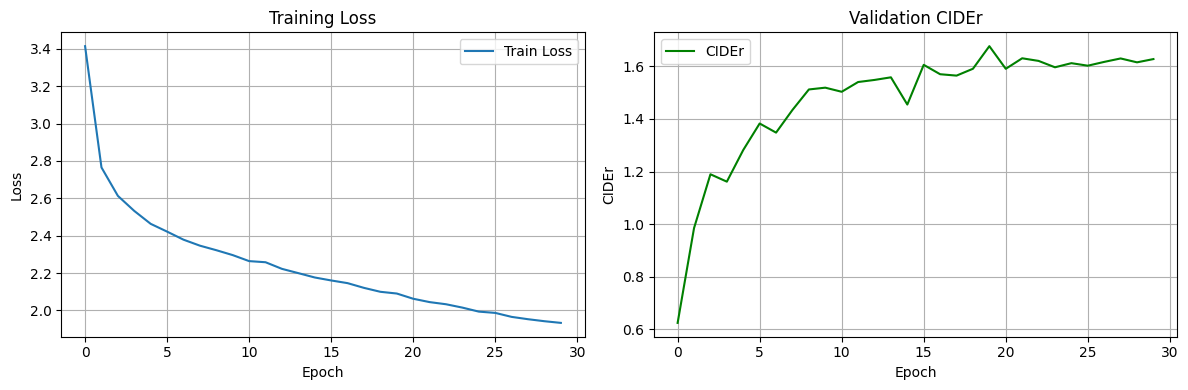

In [12]:
print("\n" + "="*70)
print("PHASE 1: Cross-Entropy Training")
print("="*70)

num_epochs_xe = 40
patience = 10
best_cider = 0.0
save_path_xe = "captioner_rsicd_xe_v2.pt"
epochs_no_improve = 0

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_epochs_xe, eta_min=1e-6
)

train_losses = []
val_bleu4s = []
val_ciders = []

for epoch in range(num_epochs_xe):
    train_loss = train_one_epoch_xe(model, train_loader, optimizer, criterion, device)
    val_bleu4, val_cider = evaluate(model, val_loader, tokenizer, criterion, device)
    
    train_losses.append(train_loss)
    val_bleu4s.append(val_bleu4)
    val_ciders.append(val_cider)
    
    print(f"\nEpoch {epoch+1}/{num_epochs_xe}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val BLEU-4: {val_bleu4*100:.2f}, CIDEr: {val_cider:.4f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    scheduler.step()
    
    # Save best model based on CIDEr (better metric than BLEU-4)
    if val_cider > best_cider:
        best_cider = val_cider
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'bleu4': val_bleu4,
            'cider': val_cider,
        }, save_path_xe)
        print(f"  ✓ Saved best XE model (CIDEr: {val_cider:.4f})")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("  Early stopping triggered")
            break

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_ciders, label='CIDEr', color='green')
plt.xlabel('Epoch')
plt.ylabel('CIDEr')
plt.title('Validation CIDEr')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_xe_curves.png', dpi=150)
print("\nSaved training curves to 'training_xe_curves.png'")

In [13]:
print("\n" + "="*70)
print("PHASE 2: SCST Fine-tuning")
print("="*70)

# Load best XE model
checkpoint = torch.load(save_path_xe, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded XE model from epoch {checkpoint['epoch']+1}")
print(f"  - BLEU-4: {checkpoint['bleu4']*100:.2f}")
print(f"  - CIDEr: {checkpoint['cider']:.4f}\n")

# Lower learning rate for SCST
optimizer = torch.optim.AdamW([
    {'params': encoder.parameters(), 'lr': 5e-6, 'weight_decay': 1e-4},
    {'params': decoder.parameters(), 'lr': 1e-4, 'weight_decay': 5e-4}
])

num_epochs_scst = 25
patience_scst = 8
best_cider_scst = checkpoint['cider']
save_path_scst = "captioner_rsicd_scst_v2.pt"
epochs_no_improve = 0

scst_rewards = []
scst_ciders = []

for epoch in range(num_epochs_scst):
    train_loss, avg_reward = train_one_epoch_scst(
        model, train_loader, tokenizer, optimizer, device
    )
    val_bleu4, val_cider = evaluate(model, val_loader, tokenizer, criterion, device)
    
    scst_rewards.append(avg_reward)
    scst_ciders.append(val_cider)
    
    print(f"\nEpoch {epoch+1}/{num_epochs_scst}")
    print(f"  Train Loss: {train_loss:.4f}, Avg Reward: {avg_reward:.4f}")
    print(f"  Val BLEU-4: {val_bleu4*100:.2f}, CIDEr: {val_cider:.4f}")
    
    if val_cider > best_cider_scst:
        best_cider_scst = val_cider
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'bleu4': val_bleu4,
            'cider': val_cider,
        }, save_path_scst)
        print(f"Saved best SCST model (CIDEr: {val_cider:.4f})")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience_scst and epoch >=10:
            print("  Early stopping triggered")
            break

# Plot SCST curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(scst_rewards, label='Avg Reward', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Reward')
plt.title('SCST Average Reward')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(scst_ciders, label='CIDEr', color='green')
plt.xlabel('Epoch')
plt.ylabel('CIDEr')
plt.title('SCST Validation CIDEr')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_scst_curves.png', dpi=150)
print("\nSaved SCST curves to 'training_scst_curves.png'")


PHASE 2: SCST Fine-tuning
Loaded XE model from epoch 20
  - BLEU-4: 45.71
  - CIDEr: 1.6766



{'testlen': 12129, 'reflen': 11277, 'guess': [12129, 11035, 9941, 8847], 'correct': [9124, 5744, 3817, 2570]}
ratio: 1.075552008512807

Epoch 1/25
  Train Loss: 0.0000, Avg Reward: 0.0000
  Val BLEU-4: 45.71, CIDEr: 1.6766


{'testlen': 12129, 'reflen': 11277, 'guess': [12129, 11035, 9941, 8847], 'correct': [9124, 5744, 3817, 2570]}
ratio: 1.075552008512807

Epoch 2/25
  Train Loss: 0.0000, Avg Reward: 0.0000
  Val BLEU-4: 45.71, CIDEr: 1.6766


KeyboardInterrupt: 

In [14]:
print("\n" + "="*70)
print("PHASE 3: Test Evaluation")
print("="*70)

checkpoint = torch.load(save_path_xe, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best SCST model from epoch {checkpoint['epoch']+1}")
print(f"  - Val BLEU-4: {checkpoint['bleu4']*100:.2f}")
print(f"  - Val CIDEr: {checkpoint['cider']:.4f}\n")

test_results, test_refs, test_hyps = test_evaluation(model, test_loader, tokenizer, device)

print("\n" + "="*70)
print("TEST RESULTS:")
print("="*70)
print(f"Number of test samples: {test_results['num_samples']}\n")
print("Scores:")
print(f"  BLEU-1:  {test_results['BLEU_1']*100:6.2f}")
print(f"  BLEU-2:  {test_results['BLEU_2']*100:6.2f}")
print(f"  BLEU-3:  {test_results['BLEU_3']*100:6.2f}")
print(f"  BLEU-4:  {test_results['BLEU_4']*100:6.2f}")
print(f"  METEOR:  {test_results['METEOR']*100:6.2f}")
print(f"  ROUGE-L: {test_results['ROUGE_L']*100:6.2f}")
print(f"  CIDEr:   {test_results['CIDEr']:6.4f}")

# Save results
output_file = 'test_predictions_v2.json'
predictions = []
for idx in range(min(len(test_refs), 100)):
    predictions.append({
        'image_id': idx,
        'ground_truth': test_refs[idx],
        'prediction': test_hyps[idx][0]
    })

with open(output_file, 'w', encoding='utf-8') as f:
    json.dump({
        'metrics': {k: float(v) if isinstance(v, (int, float)) else v 
                   for k, v in test_results.items()},
        'predictions': predictions
    }, f, indent=2, ensure_ascii=False)

print(f"\nSaved predictions to '{output_file}'")
print("\n" + "="*70)
print("Training completed!")
print("="*70)


PHASE 3: Test Evaluation
Loaded best SCST model from epoch 20
  - Val BLEU-4: 45.71
  - Val CIDEr: 1.6766

Generating captions for test set...


Test: 100%|██████████| 18/18 [04:56<00:00, 16.49s/it]



Computing metrics...
  - Computing BLEU...
{'testlen': 12238, 'reflen': 12130, 'guess': [12238, 11145, 10052, 8959], 'correct': [8111, 3613, 1869, 1058]}
ratio: 1.0089035449298427
  - Computing METEOR...
  - Computing ROUGE-L...
  - Computing CIDEr...

TEST RESULTS:
Number of test samples: 1093

Scores:
  BLEU-1:   66.28
  BLEU-2:   46.35
  BLEU-3:   34.19
  BLEU-4:   26.21
  METEOR:   27.17
  ROUGE-L:  50.78
  CIDEr:   0.6978

Saved predictions to 'test_predictions_v2.json'

Training completed!



SAMPLE PREDICTIONS FROM TEST SET:

[Example 1]
Prediction: it's a piece of green mountain .
Ground Truth: a long river flows through the mountain.

[Example 2]
Prediction: many green trees and several buildings are around an irregular pond .
Ground Truth: the angular rectangular pond has hard stony bank .

[Example 3]
Prediction: many buildings and some green trees are located in a dense residential area .
Ground Truth: some containers are dispersed in the plant.

[Example 4]
Prediction: several planes are parked near a terminal in an airport .
Ground Truth: we can see three storage tanks and a long building standing on the concrete triangle on the lawn.

[Example 5]
Prediction: many green trees are around a rectangular pond .
Ground Truth: the pond is trapezoidal in one side of which there are some trees and in other sides of which there are many tracts of farmland .

[Example 6]
Prediction: many green trees are around a building .
Ground Truth: Many large trees were planted around t

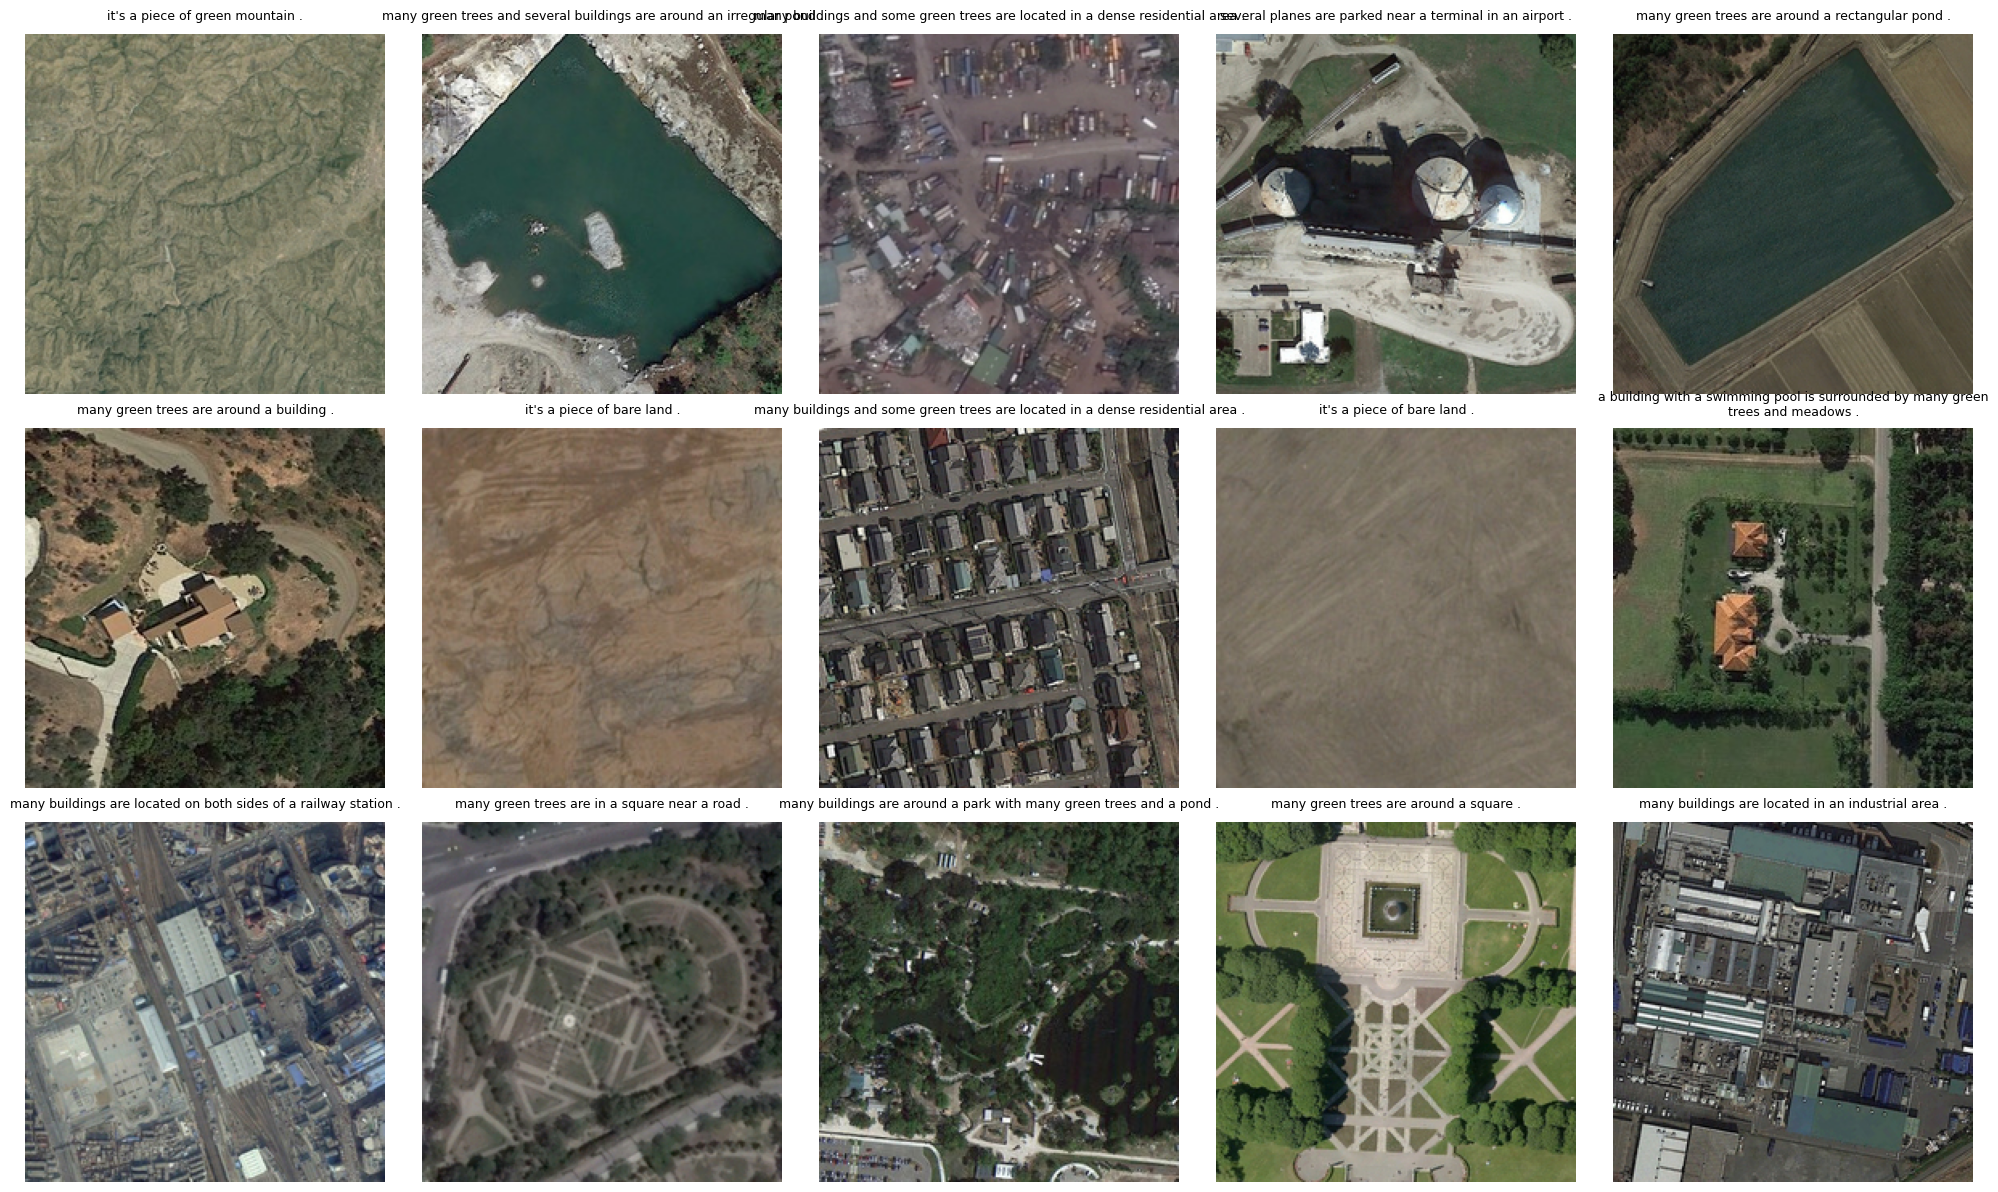


Training completed!


In [17]:
print("\n" + "="*70)
print("SAMPLE PREDICTIONS FROM TEST SET:")
print("="*70)

# Visualize random images with predictions
num_examples = 15
indices = random.sample(range(len(test_refs)), min(num_examples, len(test_refs)))

cols = 5
rows = (num_examples + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 4*rows))
axes = axes.flatten()

for ax_idx, img_idx in enumerate(indices):
    ex = test_data.data[img_idx]
    img_path = ex.get("image_path", ex.get("image"))
    
    # Load image
    if isinstance(img_path, str):
        image = Image.open(img_path).convert("RGB")
    else:
        image = ex["image"]
        if not isinstance(image, Image.Image):
            image = Image.fromarray(np.array(image))
    
    # Display image
    axes[ax_idx].imshow(image)
    axes[ax_idx].axis('off')
    
    # Add prediction as title
    pred = test_hyps[img_idx][0]
    axes[ax_idx].set_title(f"{pred}", fontsize=9, wrap=True, pad=10)
    
    # Print to console
    print(f"\n[Example {ax_idx+1}]")
    print(f"Prediction: {pred}")
    print(f"Ground Truth: {test_refs[img_idx][0]}")

# Hide unused subplots
for ax_idx in range(num_examples, len(axes)):
    axes[ax_idx].axis('off')

plt.tight_layout()
plt.savefig('test_predictions_visual.png', dpi=150, bbox_inches='tight')
print(f"\n✓ Saved visualization to 'test_predictions_visual.png'")
plt.show()

print("\n" + "="*70)
print("Training completed!")
print("="*70)